# Generate thumbnails from videos

Automatically create preview thumbnails from video files at specific timestamps or intervals.

## Problem

You have video files that need preview thumbnails for galleries, search results, or video players. Manually extracting frames doesn't scale.

| Use case | Videos | Need |
|----------|--------|------|
| Video platform | 10K videos | Preview thumbnails |
| Media library | 5K clips | Gallery previews |
| Content management | 1K uploads | Automated thumbnails |

## Solution

**What's in this recipe:**

- Extract thumbnail at a specific timestamp
- Generate multiple thumbnails per video
- Resize thumbnails to standard dimensions

You add computed columns that extract frames from videos. Thumbnails are generated automatically when you insert new videos.

### Setup

In [ ]:
%pip install -qU pixeltable

In [ ]:
import pixeltable as pxt
import pixeltable.functions as pxtf

### Load videos

In [3]:
# Create a fresh directory
pxt.drop_dir('thumbnail_demo', force=True)
pxt.create_dir('thumbnail_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'thumbnail_demo'.


In [4]:
# Create table for videos
videos = pxt.create_table('thumbnail_demo.videos', {'video': pxt.Video})

Created table 'videos'.


In [5]:
# Insert sample videos from public S3 bucket
s3_prefix = 's3://multimedia-commons/'
video_paths = [
    'data/videos/mp4/ffe/ffb/ffeffbef41bbc269810b2a1a888de.mp4',
    'data/videos/mp4/ffe/feb/ffefebb41485539f964760e6115fbc44.mp4',
]

videos.insert([{'video': s3_prefix + path} for path in video_paths])

Inserting rows into `videos`: 2 rows [00:00, 382.20 rows/s]
Inserted 2 rows with 0 errors.


2 rows inserted, 4 values computed.

video
""
""

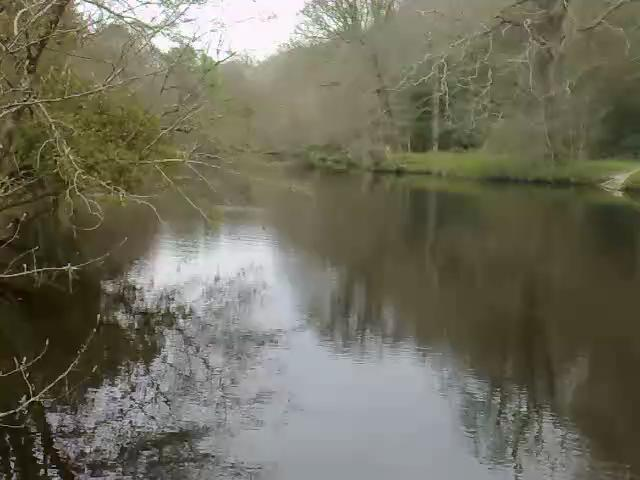
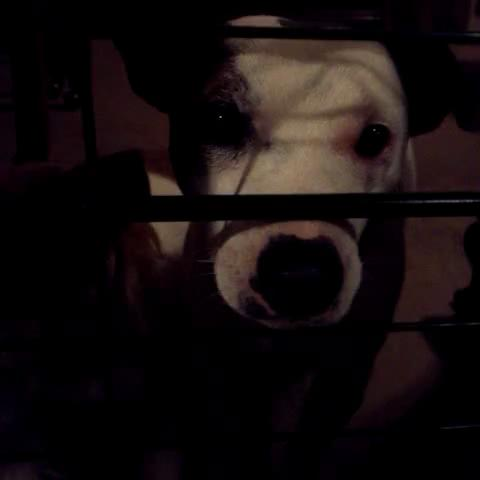

In [6]:
# View videos
videos.collect()

### Extract thumbnail at timestamp

Extract a single frame at a specific time (e.g., 1 second into the video):

In [ ]:
# Extract frame at 1 second as thumbnail
videos.add_computed_column(
    thumbnail=pxtf.video.extract_frame(videos.video, timestamp=1.0)
)

Added 2 column values with 0 errors.


2 rows updated, 2 values computed.

video,thumbnail
,
,

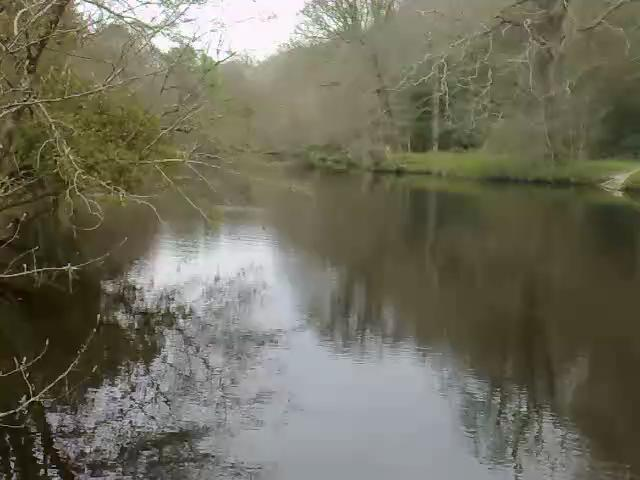
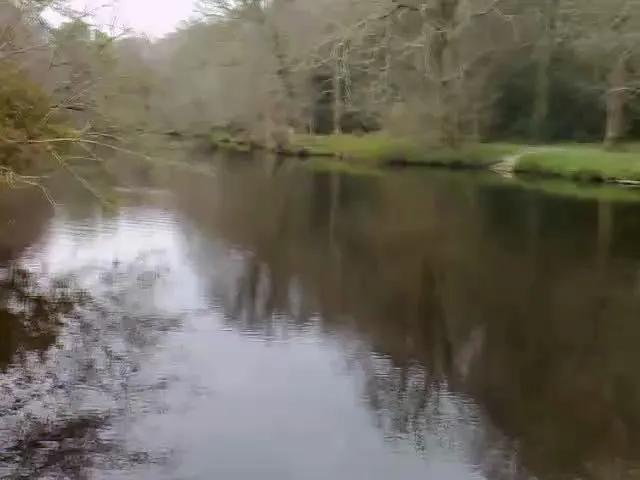
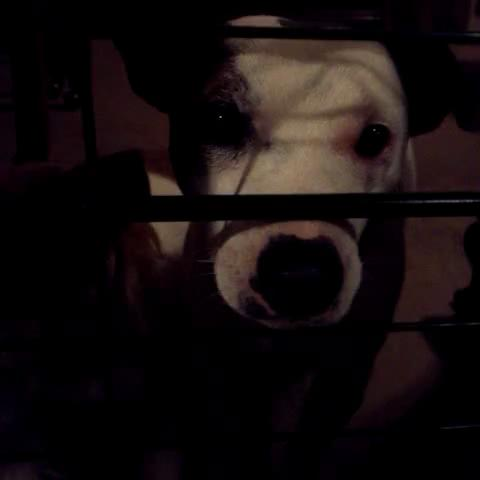
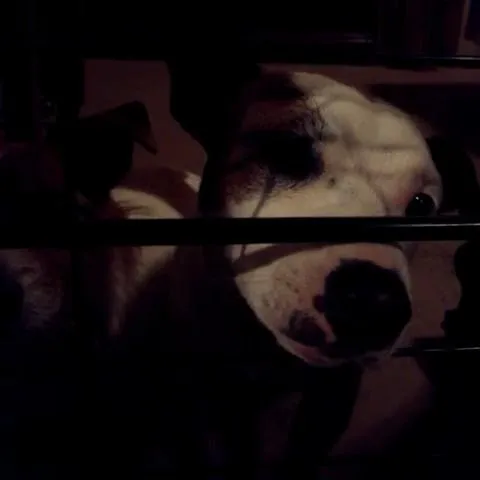

In [8]:
# View thumbnails
videos.select(videos.video, videos.thumbnail).collect()

### Resize thumbnails

Create standard-sized thumbnails for consistent display:

In [9]:
# Resize thumbnail to 320x180 (16:9 aspect ratio)
videos.add_computed_column(
    thumbnail_small=videos.thumbnail.resize((320, 180))
)

Added 2 column values with 0 errors.


2 rows updated, 2 values computed.

thumbnail_small,width,height
,320,180
,320,180

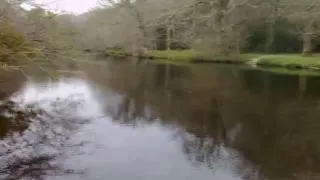
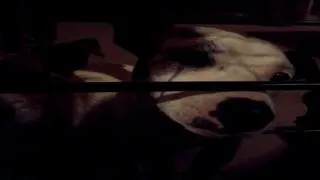

In [10]:
# View resized thumbnails with dimensions
videos.select(
    videos.thumbnail_small,
    videos.thumbnail_small.width,
    videos.thumbnail_small.height
).collect()

### Multiple thumbnails with `frame_iterator`

For preview strips or timeline thumbnails, use `frame_iterator` to extract multiple frames:

In [ ]:
# Create a view with frames extracted at 0.5 fps (one frame every 2 seconds)
frames = pxt.create_view(
    'thumbnail_demo.frames',
    videos,
    iterator=pxtf.video.frame_iterator(videos.video, fps=0.5)
)

Inserting rows into `frames`: 17 rows [00:00, 9736.88 rows/s]


frame,pos
,0
,1
,2
,3
,4
,5
,6
,7
,8
,9

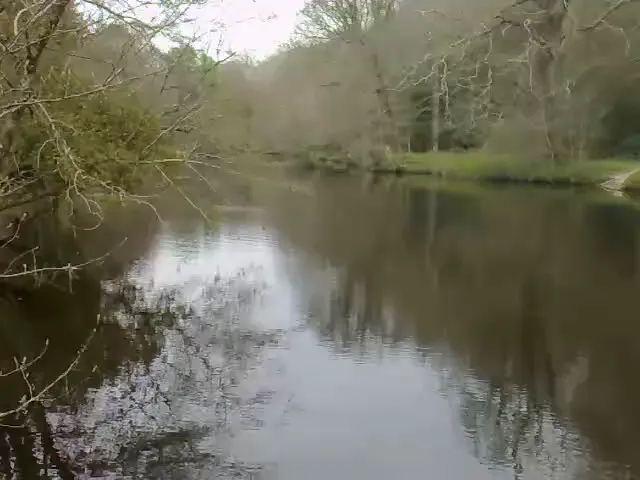
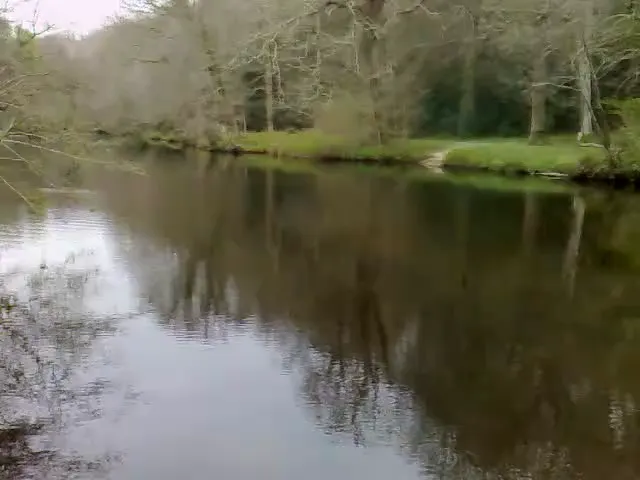
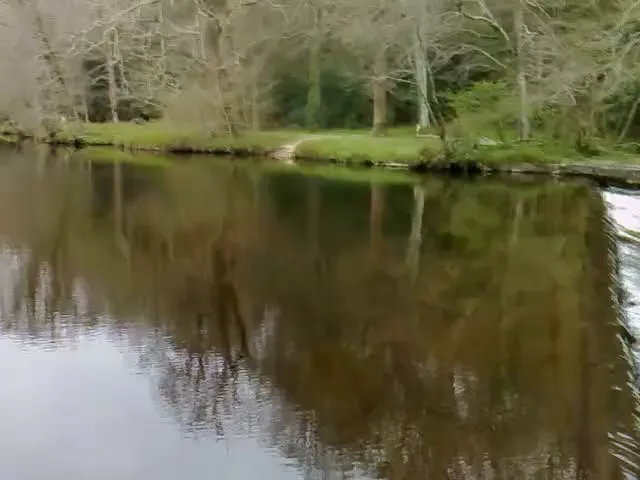
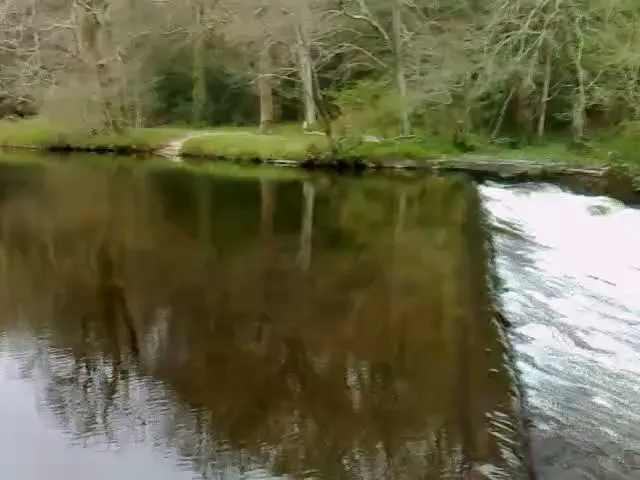
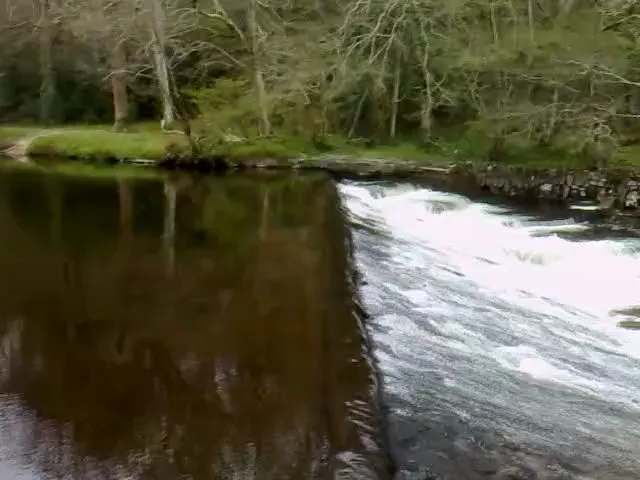
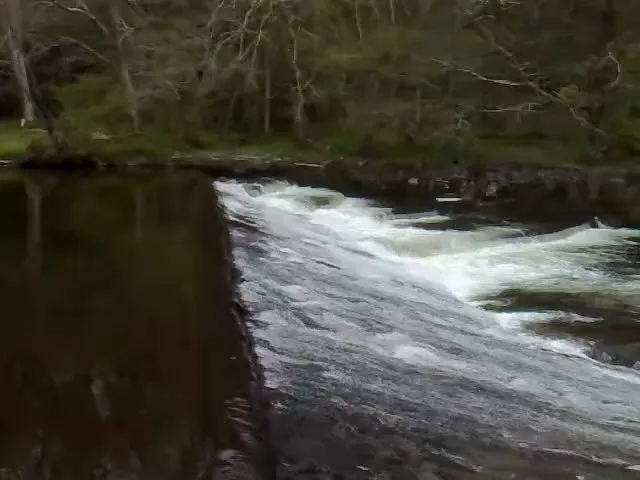
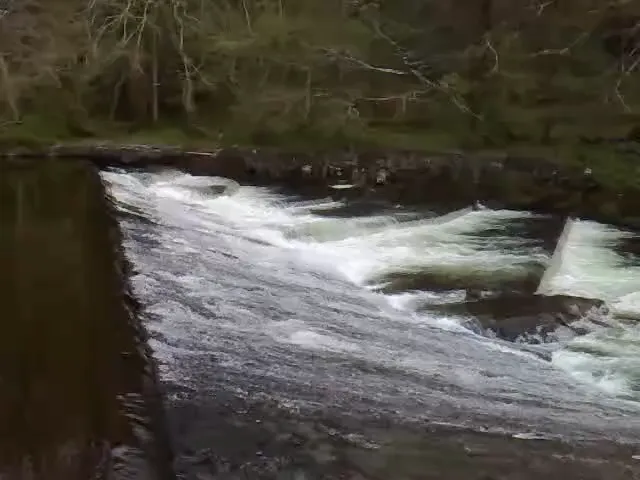
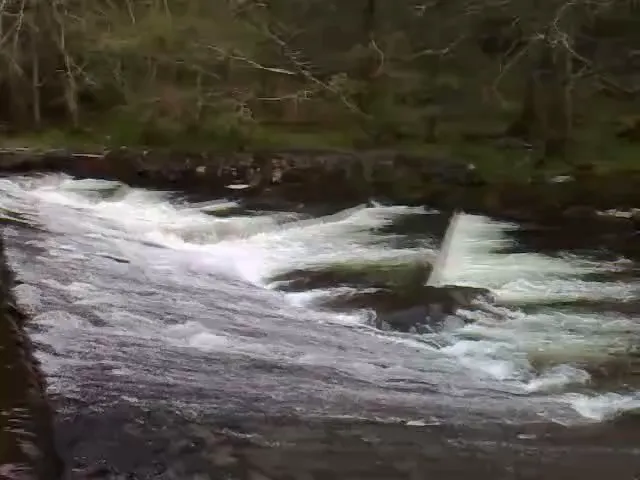
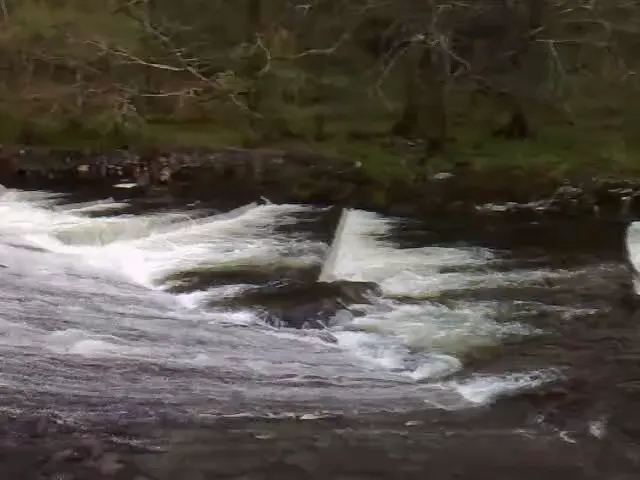
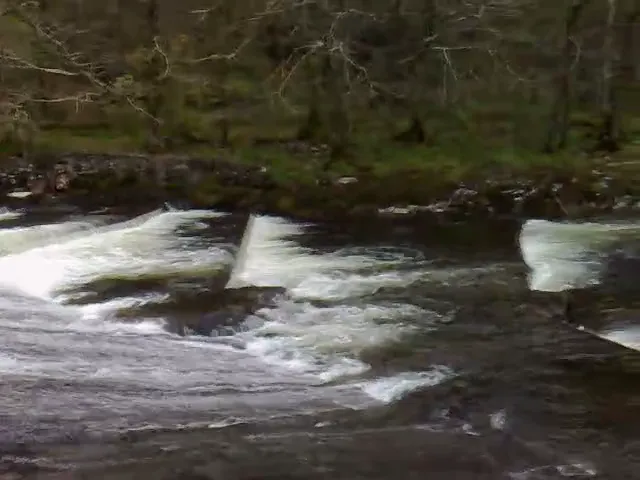

In [12]:
# View extracted frames (multiple per video)
frames.select(frames.frame, frames.pos).head(10)

## Explanation

**Thumbnail extraction methods:**

| Method | Use case |
|--------|----------|
| `extract_frame(timestamp)` | Single thumbnail at specific time |
| `frame_iterator(fps=t)` | Multiple frames at regular intervals |
| `frame_iterator(num_frames=n)` | Fixed number of evenly-spaced frames |

**Common thumbnail sizes:**

| Size | Use case |
|------|----------|
| 120x90 | Small previews, lists |
| 320x180 | Medium thumbnails, cards |
| 640x360 | Large previews, hover states |
| 1280x720 | HD thumbnails, hero images |

## See also

- [Extract frames from videos](https://docs.pixeltable.com/howto/cookbooks/video/video-extract-frames) - Detailed frame extraction guide
- [Load media from S3](https://docs.pixeltable.com/howto/cookbooks/data/data-import-s3) - Import videos from cloud storage
- [Transform images with PIL](https://docs.pixeltable.com/howto/cookbooks/images/img-pil-transforms) - Resize and crop images